## CRISP-DM Phase 3. Data Preparation

The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools

In [1]:
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import warnings 
warnings.filterwarnings('ignore')

# Load data
df: pd.DataFrame = utils.load_original_data()

# Data preprocessing object
processor = data_processor.DataProcessor(df)

### Converting Target Variable into binary values in conformance with a classification problem

In [2]:
# Convert Financial Distress column into 0 or 1
df['Financial Distress'] = [0 if x > -0.50 else 1 for x in df['Financial Distress']]

df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [3]:
# Create feature matrix and target vector 
X, y = processor.create_feature_matrix_and_target_vector("Financial Distress")

### Balancing Data

Two different techniques were combined to address class imbalance:
- SMOTE: Oversample the minority class  
- Random Undersampling: Undersample the majority class 

Counter({0: 3536, 1: 136})


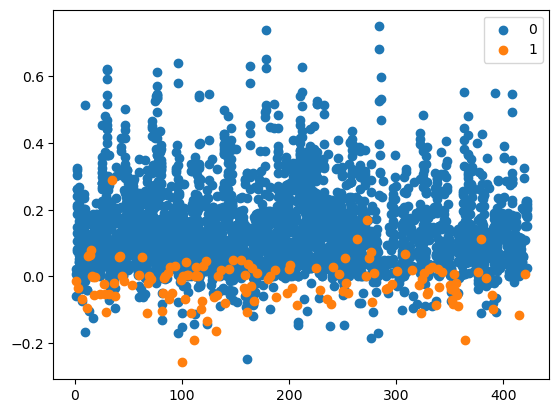

In [68]:
# Check class distribution
processor.class_distribution(X,y)

Counter({0: 2120, 1: 1060})


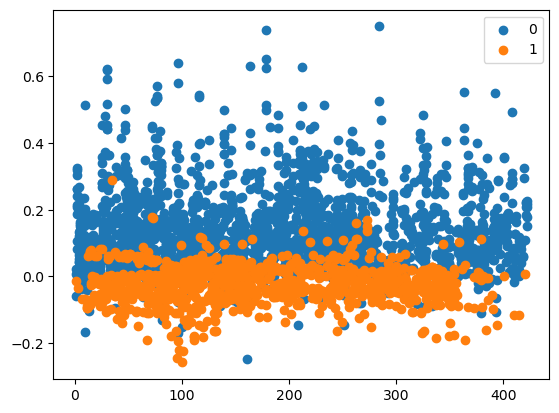

In [18]:
# Transform data with SMOTE for minority class and RandomUnderSampler for majority class to tackle class imbalance
X_sampled, y_sampled = processor.transform(X, y,0.3,0.5)

 The final class distribution after this sequence of transforms matches expectations with a 1:2 ratio or about 2,000 examples in the majority class and about 1,000 examples in the minority class.

In [28]:
sampled_sorted = X_sampled.sort_values(by=['Company'])
sampled_sorted

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
3,1,4,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
0,1,1,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
13,2,10,1.7232,0.208630,0.53398,0.78651,0.293030,0.329800,1.35480,0.265260,...,100.000,100.00,100.000,17.125,14.5,-7.0,29,2.282600,16,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,422,14,1.6148,0.176760,0.36369,0.18442,0.169550,0.197860,1.58420,0.958450,...,91.700,227.50,214.500,21.000,20.5,8.6,37,0.611030,8,45
3669,422,12,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,0.971860,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43
3665,422,8,2.0609,0.149950,0.18973,0.14381,0.132120,0.199190,1.98920,1.042700,...,84.660,73.20,63.880,16.000,12.0,1.2,37,0.351440,2,39
3668,422,11,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,1.000100,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42


In [20]:
# check if Time is monotonic and increasing for each group/company 
print("Time monotonic and increasing for each group/company in original data: {}".format(processor.check_time_monotonicity(X, "Time")))
print("Time monotonic and increasing for each group/company in sampled data: {}".format(processor.check_time_monotonicity(X_sampled, "Time")))

Time monotonic and increasing for each group/company in original data: True
Time monotonic and increasing for each group/company in sampled data: False


- It seems that the temporal order of the 'Time' column is not being preserved within each group (company) in the sampled data.

In [27]:
# Preserve temporal order of data for each group/company
X_sampled_sorted = X_sampled.sort_values(by=['Company', 'Time'])
print(X_sampled_sorted.head())

# sort y_sampled according to X_sampled_sorted 
y_sampled_sorted = y_sampled[X_sampled_sorted.index]
print(y_sampled_sorted.head())

   Company  Time      x1        x2       x3       x4        x5        x6  \
0        1     1  1.2810  0.022934  0.87454  1.21640  0.060940  0.188270   
1        1     2  1.2700  0.006454  0.82067  1.00490 -0.014080  0.181040   
2        1     3  1.0529 -0.059379  0.92242  0.72926  0.020476  0.044865   
3        1     4  1.1131 -0.015229  0.85888  0.80974  0.076037  0.091033   
4        2     1  1.0623  0.107020  0.81460  0.83593  0.199960  0.047800   

        x7        x8  ...      x74    x75     x76     x77   x78  x79  x80  \
0  0.52510  0.018854  ...   85.437  27.07  26.102  16.000  16.0  0.2   22   
1  0.62288  0.006423  ...  107.090  31.31  30.194  17.000  16.0  0.4   22   
2  0.43292 -0.081423  ...  120.870  36.07  35.273  17.000  15.0 -0.2   22   
3  0.67546 -0.018807  ...   54.806  39.80  38.377  17.167  16.0  5.6   22   
4  0.74200  0.128030  ...   85.437  27.07  26.102  16.000  16.0  0.2   29   

        x81  x82  x83  
0  0.060390   30   49  
1  0.010636   31   50  
2 -0.455

### Scaling

In [29]:
X_scaled : pd.DataFrame = processor.scale()
X_scaled

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,-1.547615,-1.606591,-0.073530,-0.889790,1.454750,0.608946,-0.752754,0.387378,-0.250547,-0.009118,...,-0.083982,-1.003137,-0.979380,-0.873022,0.283316,0.349666,0.304413,-0.390080,1.783244,1.163525
1,-1.547615,-1.360496,-0.081102,-1.027125,1.151905,0.239109,-1.353457,0.353036,-0.155933,-0.009121,...,1.212300,-0.937551,-0.915781,-0.382796,0.283316,0.374081,0.304413,-0.408740,1.888901,1.236450
2,-1.547615,-1.114400,-0.230545,-1.575751,1.723920,-0.242885,-1.076758,-0.293797,-0.339742,-0.009142,...,2.037255,-0.863921,-0.836842,-0.382796,-0.070258,0.300835,0.304413,-0.583737,1.994557,1.309375
3,-1.547615,-0.868304,-0.189106,-1.207824,1.366713,-0.102155,-0.631868,-0.074498,-0.105055,-0.009127,...,-1.917741,-0.806224,-0.788598,-0.300928,0.283316,1.008882,0.304413,-0.534764,2.100214,1.382300
4,-1.539069,-1.606591,-0.224075,-0.189054,1.117781,-0.056358,0.360413,-0.279855,-0.040670,-0.009093,...,-0.083982,-1.003137,-0.979380,-0.873022,0.283316,0.349666,1.236806,0.056448,-0.646859,-0.440828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2.050408,0.608269,0.600718,0.609885,-2.560149,-1.193060,0.168319,0.435496,1.392953,-0.008869,...,0.787849,0.124977,0.169164,-0.321518,-0.247045,-0.529289,2.302398,-0.249068,-0.963829,0.580124
3668,2.050408,0.854364,0.394899,0.722805,-2.332018,-1.139656,0.389479,0.394978,1.116795,-0.008890,...,0.278987,0.596765,0.672734,1.087883,-0.247045,-1.627982,2.302398,-0.248453,-0.858173,0.653049
3669,2.050408,1.100460,0.221707,0.652220,-1.992406,-1.143906,0.310047,0.366573,0.876438,-0.008897,...,0.015576,1.299033,1.383016,1.087883,-0.247045,-2.140706,2.302398,-0.231805,-0.752516,0.725974
3670,2.050408,1.346556,0.117834,0.464548,-1.734255,-1.180487,0.137651,0.303826,0.730425,-0.008900,...,0.362799,1.721322,1.793332,2.068336,2.404759,1.106544,2.302398,-0.224919,-0.646859,0.798899


### Lag Values

In [37]:
# Helper function to create lagged features
def lagged_features(df_long, lag_features, window=2, lag_prefix='lag', lag_prefix_sep='_'):
    """
    Function calculates lagged features (only for columns mentioned in lag_features)
    based on time_feature column. The highest value of time_feature is retained as a row
    and the lower values of time_feature are added as lagged_features
    :param df_long: Data frame (longitudinal) to create lagged features on
    :param lag_features: A list of columns to be lagged
    :param window: How many lags to perform (0 means no lagged feature will be produced)
    :param lag_prefix: Prefix to name lagged columns.
    :param lag_prefix_sep: Separator to use while naming lagged columns
    :return: Data Frame with lagged features appended as columns
    """
    if not isinstance(lag_features, list):
        # So that while sub-setting DataFrame, we don't get a Series
        lag_features = [lag_features]

    if window <= 0:
        return df_long

    df_working = df_long[lag_features].copy()
    df_result = df_long.copy()
    for i in range(1, window+1):
        df_temp = df_working.shift(i)
        df_temp.columns = [lag_prefix + lag_prefix_sep + str(i) + lag_prefix_sep + x
                           for x in df_temp.columns]
        df_result = pd.concat([df_result.reset_index(drop=True),
                               df_temp.reset_index(drop=True)],
                               axis=1)

    return df_result


# Now split Data Set into groups (based on Company) and create lagged features for each group
grouped_company = df.groupby('Company')
cols_to_lag = [col for col in df.columns if col.startswith('x')]
df_cross = pd.DataFrame()

for name, group in grouped_company:
    # For each group, calculate lagged features and rbind to df_cross
    print('----------------------------------------------------')
    print('Working on group:', name, 'with shape', group.shape)
    print(group.head())
    df_cross = pd.concat([df.reset_index(drop=True),
                          lagged_features(group, cols_to_lag).reset_index(drop=True)],
                         axis=0)
    print('Shape of df_', df.shape)
    
# Remove rows with NAs
df = df.dropna()
df.head()

----------------------------------------------------
Working on group: 1 with shape (4, 86)
   Company  Time Financial Distress      x1        x2       x3       x4  \
0        1     1                  0  1.2810  0.022934  0.87454  1.21640   
1        1     2                  0  1.2700  0.006454  0.82067  1.00490   
2        1     3                  0  1.0529 -0.059379  0.92242  0.72926   
3        1     4                  1  1.1131 -0.015229  0.85888  0.80974   

         x5        x6       x7  ...      x74    x75     x76     x77   x78  \
0  0.060940  0.188270  0.52510  ...   85.437  27.07  26.102  16.000  16.0   
1 -0.014080  0.181040  0.62288  ...  107.090  31.31  30.194  17.000  16.0   
2  0.020476  0.044865  0.43292  ...  120.870  36.07  35.273  17.000  15.0   
3  0.076037  0.091033  0.67546  ...   54.806  39.80  38.377  17.167  16.0   

   x79  x80       x81  x82  x83  
0  0.2   22  0.060390   30   49  
1  0.4   22  0.010636   31   50  
2 -0.2   22 -0.455970   32   51  
3  5.6   2

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


### Spliting Data

This dataset prevents us from using sklearn.model_selection.TimeSeriesSplit, as the assumption of this function is that each row represents a data point from a unique instance of time (and the rows are arranged as per increasing value of time).

To implement Forward Chaining the following approach was designed:

- Split the Dataset into multiple groups - 1 group per Company
- For each group, derive the indices for Forward Chaining
- Combine the list of indices per group into 1 final index list

In [63]:
X.head(20)

# X dataframe group by company column   

grouped_company = X.groupby('Company')

# print a dataframe grouped by company column
for name, group in grouped_company:
    print('----------------------------------------------------')
    print('Working on group:', name, 'with shape', group.shape)
    print(group.head())
    print('Shape of df_', df.shape)

----------------------------------------------------
Working on group: 1 with shape (1, 85)
   Company  Time      x1        x2       x3       x4        x5        x6  \
3        1     4  1.1131 -0.015229  0.85888  0.80974  0.076037  0.091033   

        x7        x8  ...     x74   x75     x76     x77   x78  x79  x80  \
3  0.67546 -0.018807  ...  54.806  39.8  38.377  17.167  16.0  5.6   22   

       x81  x82  x83  
3 -0.32539   33   52  

[1 rows x 85 columns]
Shape of df_ (3672, 86)
----------------------------------------------------
Working on group: 2 with shape (8, 85)
    Company  Time       x1        x2       x3       x4       x5        x6  \
6         2     3  0.97059  0.076064  0.90677  0.80980  0.16592 -0.024649   
15        2    12  2.17230  0.319450  0.44139  0.94698  0.42740  0.481260   
7         2     4  1.05900  0.130200  0.81811  0.87599  0.23445  0.045576   
11        2     8  1.54430  0.240910  0.59073  1.07700  0.32561  0.301170   
8         2     5  1.12450  0.1478

In [64]:
X.groupby('Company').groups

{1: [3], 2: [6, 15, 7, 11, 8, 5, 4, 16], 3: [18], 4: [24, 29, 27, 21, 22], 5: [33, 35, 36, 38, 41, 43], 6: [49, 58, 51, 48, 50, 53], 7: [68, 69, 65, 66, 70, 62, 63, 71, 3695], 8: [85, 74, 79, 80, 83, 84, 77, 76, 75], 9: [98, 87, 96, 88, 93], 10: [104, 100, 107, 112, 113, 110, 111], 11: [119, 117, 120, 114, 121, 116, 122], 12: [123, 3974, 4248, 4324], 13: [124, 125], 14: [127, 133, 3734, 3844, 3994, 4171, 4257, 4344], 15: [137, 136, 135, 139, 3935, 3983, 4190], 16: [140, 142, 144, 3736, 3924, 4208], 17: [150, 149, 147, 145, 151, 152, 146, 153, 4142, 4252], 18: [157, 154, 159, 4163], 19: [160, 162], 20: [176, 169, 172, 166, 170, 163, 167, 174], 21: [188, 183, 185, 186, 179, 187, 184, 189], 22: [195, 200, 201, 196, 191, 194, 198, 193, 3931, 4312], 23: [208, 216, 213, 217, 206, 211, 210, 218, 4556], 24: [219, 226, 231, 230, 220, 221, 224, 227, 228, 225, 222, 223, 3894, 4011, 4461], 25: [241, 242, 236, 243, 246, 234, 4082], 26: [253, 260, 255, 258, 254, 248, 247, 252, 251, 259, 4016, 4199, 

In [ ]:
def __init__(self, X:pd.DataFrame, y:pd.DataFrame, n_splits:int=5) -> None:
        """
        Constructor for TimeSeriesCrossValidator class
        :param X: Feature matrix
        :param y: Target vector
        :param n_splits: Number of splits
        :return: None
        """
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.groups = self.X.groupby('Company').groups
        self.group_indexes = self._get_group_indexes()
        print(" Group Indexes:")
        print(self.group_indexes)
        print("-----------------------")
        self.indexes = self._get_indexes()
        print(" Indexes:")
        print(self.indexes)

def _get_group_indexes(self) -> list[list[int]]:
    """
    Get the indexes for each group
    :return: List of indexes for each group
    """
    group_indexes = []
    for group in self.groups:
        group_indexes.append(self.groups[group].tolist())
    return group_indexes

def _get_indexes(self) -> list[list[int]]:
    """
    Get the indexes for each split 
    :return: List of indexes for each split
    """
    indexes = []
    for i in range(self.n_splits):
        indexes.append([])
    for group_index in self.group_indexes:
        for i in range(self.n_splits):
            indexes[i].extend(group_index[i::self.n_splits]) # group_index[i::self.n_splits] is the same as group_index[i], group_index[i+self.n_splits], group_index[i+2*self.n_splits], ...
    return indexes




In [46]:
class TimeSeriesCrossValidator:
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, n_splits:int=5) -> None:
        """
        Constructor for TimeSeriesCrossValidator class
        :param X: Feature matrix
        :param y: Target vector
        :param n_splits: Number of splits
        :return: None
        """
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.groups = self.X.groupby('Company').groups
        self.group_indexes = self._get_group_indexes()
        print(" Group Indexes:")
        print(self.group_indexes)
        print("-----------------------")
        self.indexes = self._get_indexes()
        print(" Indexes:")
        print(self.indexes)

    def _get_group_indexes(self) -> list[list[int]]:
        """
        Get the indexes for each group
        :return: List of indexes for each group
        """
        group_indexes = []
        for group in self.groups:
            group_indexes.append(self.groups[group].tolist())
        return group_indexes

    def _get_indexes(self) -> list[list[int]]:
        """
        Get the indexes for each split 
        :return: List of indexes for each split
        """
        indexes = []
        for i in range(self.n_splits):
            indexes.append([])
        for group_index in self.group_indexes:
            for i in range(self.n_splits):
                indexes[i].extend(group_index[i::self.n_splits]) # group_index[i::self.n_splits] is the same as group_index[i], group_index[i+self.n_splits], group_index[i+2*self.n_splits], ...
        return indexes

    def split(self) -> tuple:
        """
        Split the data into train and test sets
        :return: Train and test sets
        """
        for i in range(self.n_splits):
            train_indexes = [index for j, index in enumerate(self.indexes) if j != i]
            train_indexes = [item for sublist in train_indexes for item in sublist]
            test_indexes = self.indexes[i]
            yield self.X.iloc[train_indexes], self.X.iloc[test_indexes], self.y.iloc[train_indexes], self.y.iloc[test_indexes]

    def evaluate(self, model:object, scoring:str='accuracy') -> list[float]:
        """
        Evaluate the model using cross validation
        :param model: Model to be evaluated
        :param scoring: Scoring metric
        :return: List of scores
        """
        scores = []
        for X_train, X_test, y_train, y_test in self.split():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        return scores
    
# with TimeSeriesCrossValidator class, we can now split data into train and test sets to model time series data with cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a TimeSeriesCrossValidator object
tscv = TimeSeriesCrossValidator(X_scaled, y, n_splits=5)

# Evaluate the model
scores = tscv.evaluate(rf)
print('Scores:', scores)

import numpy as np
print('Mean Score:', np.mean(scores))

# Create a confusion matrix
y_pred = rf.predict(X_scaled)
confusion_matrix(y, y_pred)


 Group Indexes:
[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [18], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113], [114, 115, 116, 117, 118, 119, 120, 121, 122], [123], [124, 125], [126, 127, 128, 129, 130, 131, 132, 133], [134, 135, 136, 137, 138, 139], [140, 141, 142, 143, 144], [145, 146, 147, 148, 149, 150, 151, 152, 153], [154, 155, 156, 157, 158, 159], [160, 161, 162], [163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176], [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190], [191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], [205, 206, 207, 208, 209

array([[3535,    1],
       [  15,  121]], dtype=int64)

### Beta Dev

In [27]:
# Create Time-Series sampling function to draw train-test splits
def ts_sample(df_input, train_rows, test_rows):
    """
    Function to draw specified train_rows and test_rows in time-series rolling sampling format
    :param df_input: Input DataFrame
    :param train_rows: Number of rows to use as training set
    :param test_rows: Number of rows to use as test set
    :return: List of tuples. Each tuple contains 2 lists of indexes corresponding to train and test index
    """
    if df_input.shape[0] <= train_rows:
        return [(df_input.index, pd.Index([]))]

    i = 0
    train_lower, train_upper = 0, train_rows + test_rows*i
    test_lower, test_upper = train_upper, min(train_upper + test_rows, df_input.shape[0])

    result_list = []
    while train_upper < df_input.shape[0]:
        # Get indexes into result_list
        # result_list += [([df_input.index[train_lower], df_input.index[train_upper]],
        #                  [df_input.index[test_lower], df_input.index[test_upper]])]
        result_list += [(df_input.index[train_lower:train_upper],
                         df_input.index[test_lower:test_upper])]

        # Update counter and calculate new indexes
        i += 1
        train_upper = train_rows + test_rows*i
        test_lower, test_upper = train_upper, min(train_upper + test_rows, df_input.shape[0])

    return result_list

    

In [28]:
# For each group, apply function ts_sample
# Depending on size of group, the output size of ts_sample (which is a list of (train_index, test_index))
# tuples will vary. However, we want the size of each of these lists to be equal.
# To do that, we will augment the smaller lists by appending the last seen train_index and test_index
# For example:
# group 1 => [(Int64Index([1, 2, 3], dtype='int64'), (Int64Index[4, 5], dtype='int64)),
#             (Int64Index([1, 2, 3, 4, 5], dtype='int64'), (Int64Index([6], dtype='int64'))]
# group 2 => [(Int64Index([10, 11, 12], dtype='int64'), (Int64Index[13, 14], dtype='int64')),
#             (Int64Index([10, 11, 12, 13, 14), Int64Index([15, 16])),
#             (Int64Index([10, 11, 12, 13, 14, 15, 16]), Int64Index([17, 18]))]
# Above, group 2 has 3 folds whereas group 1 has 2. We will augment group 2 to also have 3 folds:
# group 1 => [(Int64Index([1, 2, 3], dtype='int64'), (Int64Index[4, 5], dtype='int64)),
#             (Int64Index([1, 2, 3, 4, 5], dtype='int64'), (Int64Index([6], dtype='int64')),
#             (Int64Index([1, 2, 3, 4, 5, 6]), Int64Index([]))]
grouped_company_cross = df_cross.groupby('Company')
acc = []
max_size = 0
for name, group in grouped_company_cross:
    # For each group, calculate ts_sample and also store largest ts_sample output size
    group_res = ts_sample(group, 4, 4)
    acc += [group_res]
    # print('Working on name:' + str(name))
    # print(acc)

    if len(group_res) > max_size:
        # Update the max_size that we have observed so far
        max_size = len(group_res)

        # All existing lists (apart from the one added latest)in acc need to be augmented
        # to match the new max_size by appending the last value in those list (combining train and test)
        for idx, list_i in enumerate(acc):
            if len(list_i) < max_size:
                last_train, last_test = list_i[-1][0], list_i[-1][1]
                list_i[len(list_i):max_size] = [(last_train.union(last_test),
                                                 pd.Index([]))] * (max_size - len(list_i))

                acc[idx] = list_i

    elif len(group_res) < max_size:
        # Only the last appended list (group_res) needs to be augmented
        last_train, last_test = acc[-1][-1][0], acc[-1][-1][1]
        acc[-1] = acc[-1] + [(last_train.union(last_test), pd.Index([]))] * (max_size - len(acc[-1]))


print(acc[0:2])

[[(Index([0, 1, 2, 3], dtype='int64'), Index([], dtype='object')), (Index([0, 1, 2, 3], dtype='object'), Index([], dtype='object')), (Index([0, 1, 2, 3], dtype='object'), Index([], dtype='object'))], [(Index([4, 5, 6, 7], dtype='int64'), Index([8, 9, 10, 11], dtype='int64')), (Index([4, 5, 6, 7, 8, 9, 10, 11], dtype='int64'), Index([12, 13, 14, 15], dtype='int64')), (Index([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64'), Index([16, 17], dtype='int64'))]]


In [29]:
# acc now contains a list of lists, where each internal list contains tuples of train_index, test_index
# [[(group_1_train_index1, group_1_test_index1), (group_1_train_index2, group_1_test_index2)],
#  [(group_2_train_index1, group_2_test_index1), (group_2_train_index2, group_2_test_index2)],
#  [(group_3_train_index1, group_3_test_index1), (group_3_train_index2, group_3_test_index2)]]
#
# Our goal is to drill-down by removing group-divisions:
# [(train_index1, test_index1), (train_index2, test_index2)]
flat_acc = []
for idx, list_i in enumerate(acc):
    if len(flat_acc) == 0:
        flat_acc += list_i
        continue

    for inner_idx, tuple_i in enumerate(list_i):
        flat_acc[inner_idx] = (flat_acc[inner_idx][0].union(tuple_i[0]),
                               flat_acc[inner_idx][1].union(tuple_i[1]))


print(flat_acc[0:2])

[(Index([   0,    1,    2,    3,    4,    5,    6,    7,   18,   19,
       ...
       3656, 3657, 3658, 3659, 3660, 3661, 3664, 3665, 3666, 3667],
      dtype='int64', length=1498), Index([   8,    9,   10,   11,   23,   24,   25,   26,   37,   38,
       ...
       3641, 3642, 3643, 3644, 3662, 3663, 3668, 3669, 3670, 3671],
      dtype='object', length=1060)), (Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671],
      dtype='object', length=2558), Index([   0,    1,    2,    3,   12,   13,   14,   15,   27,   28,
       ...
       3592, 3603, 3604, 3605, 3606, 3616, 3617, 3618, 3619, 3645],
      dtype='object', length=821))]


In [33]:
#flat_acc is now a list of tuples of train_index, test_index

[(Index([   0,    1,    2,    3,    4,    5,    6,    7,   18,   19,
         ...
         3656, 3657, 3658, 3659, 3660, 3661, 3664, 3665, 3666, 3667],
        dtype='int64', length=1498),
  Index([   8,    9,   10,   11,   23,   24,   25,   26,   37,   38,
         ...
         3641, 3642, 3643, 3644, 3662, 3663, 3668, 3669, 3670, 3671],
        dtype='object', length=1060)),
 (Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         ...
         3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671],
        dtype='object', length=2558),
  Index([   0,    1,    2,    3,   12,   13,   14,   15,   27,   28,
         ...
         3592, 3603, 3604, 3605, 3606, 3616, 3617, 3618, 3619, 3645],
        dtype='object', length=821)),
 (Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         ...
         3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671],
        dtype='object', length=3375),
  Index([   4,    5,    6,    7,   16,   17,   31,

In [23]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import numpy as np
# confusion matrix
from sklearn.metrics import confusion_matrix


In [24]:
# For each entry in flat_acc, perform train and test and plot metrics
dependent_cols = [col for col in df_model.columns if col != 'Financial Distress']
independent_col = ['Financial Distress']
for idx, tuple_i in enumerate(flat_acc):
    print('---------------------------------------')
    X_train, X_test = df_model.loc[tuple_i[0]][dependent_cols], df_model.loc[tuple_i[1]][dependent_cols]
    y_train, y_test = df_model.loc[tuple_i[0]][independent_col], df_model.loc[tuple_i[1]][independent_col]
    
    # Fit logistic regression model to train data and test on test data
    lr_mod = LogisticRegression(C=0.01, penalty='l2')  # These should be determined by nested cv
    lr_mod.fit(X_train, y_train)
    
    y_pred_proba = lr_mod.predict_proba(X_test)
    y_pred = lr_mod.predict(X_test)
    
    # Print Confusion Matrix and ROC AUC score
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    
    print('ROC AUC score:')
    print(roc_auc_score(y_test['Financial Distress'].astype(int), y_pred_proba[:, 1]))

---------------------------------------
Confusion Matrix:
[[1006   10]
 [  37    7]]
ROC AUC score:
0.8255637079455977
---------------------------------------
Confusion Matrix:
[[792   3]
 [ 26   0]]
ROC AUC score:
0.8104499274310595
---------------------------------------
Confusion Matrix:
[[287   0]
 [ 13   1]]
ROC AUC score:
0.8432055749128919


### Feature Extraction and Selection

Python's scikit-learn module has a TimeSeriesSplit function that can help run Forward Chaining. However, the function makes an assumption that the entire DataFrame is to be treated as one entity. Whereas,  Financial Distress Prediction Data Set is composed of groups of data (row-wise) each of which group should be treated to Forward Chaining separately.

rfe

### Save Data

In [30]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X)
df_model['Financial Distress'] = y

# save data
with open('../data/processed/financial_data_processed.pkl', 'wb') as f:
    pkl.dump(df_model, f)